In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

When the data was manually checked, below observations were found: <br> 
1. There were NA values in 'MonthlyIncome' and 'NumberOfDependents'. I decided to replace NA values of 'MonthlyIncome' with it's median and NA values of 'NumberOfDependents' with 0.<br>
<br>
2. 'NumberOfTimes90DaysLate' and 'NumberOfTime30-59DaysPastDueNotWorse' had values 96 and 98. If we think about it, this seems to impossible since 96*90/365 ~ 24 years. When I further checked such records, I saw that 'RevolvingUtilizationOfUnsecuredLines' was 0.999 for all such records. Since the count of all such records was very less as compared to our whole sample count, I decided to drop such records from our analysis. 

In [2]:
def clean(df):
    '''
    Function to clean our data
    It takes dataframe as input and returns back a cleaned dataframe
    '''
    #print(df)
    #remove rows with 98 and 96 in our data
    df = df[df["NumberOfTimes90DaysLate"] != 98]
    #print(df)
    df = df[df["NumberOfTimes90DaysLate"] != 96]
    #print(df)
    
    #fill NA values with it's median for 'MonthlyIncome'
    df["MonthlyIncome"].fillna(df["MonthlyIncome"].median(), inplace=True)
    #fill NA values with zeroes for 'NumberOfDependents'
    df["NumberOfDependents"].fillna(0, inplace=True)
    #print(df)
    return df


In [3]:
def plot_dlq(df):
    '''
    The plot_dlq() function will be used for plotting the total number of records with SeriousDlqin2yrs and no SeriousDlqin2yrs
    It takes in the dataframe and displays the pie chart.
    '''
    dlq_df = df.groupby(['SeriousDlqin2yrs']).size()
    count_dlq = dlq_df[1]
    count_nondlq = dlq_df[0]
    print 'Based on the sample of data, {} people were delinquent whereas {} were not.\n'.format(count_dlq, count_nondlq)
    print dlq_df
    
    explode = (0.1, 0)
    labels = 'Non Delinquent', 'Delinquent'
    colors = ['gold', 'lightskyblue']

    pie_chart = dlq_df.plot.pie(explode=explode, labels=labels, colors=colors,
            autopct='%1.2f%%', shadow=True, startangle = 90)
    pie_chart.axis('equal')
    pie_chart.set_ylabel('')
    plt.show()

In [4]:
def RF(train):
    '''
    Random Forest Regression and calculating Coefficient of determination R^2 of the prediction and AUC-ROC score
    '''
    Y_train = train["SeriousDlqin2yrs"]
    X_train = train.drop("SeriousDlqin2yrs",axis=1)

    random_forest = RandomForestRegressor(n_estimators = 200, oob_score=True)
    random_forest.fit(X_train, Y_train)
    
    
    print random_forest.score(X_train, Y_train)
    #print random_forest.get_params()
    print "AUC - ROC : ", roc_auc_score(Y_train,random_forest.oob_prediction_)
    return random_forest

In [16]:
df_training = pd.read_csv('cs-training.csv')
df_testing = pd.read_csv('cs-test.csv')
# BASIC OBSERVATIONS OF DATA
#print df_training.info()
#print
#print
#print df_training.describe()

In [17]:
df_training = clean(df_training)

In [18]:
df_testing = clean(df_testing)

Based on the sample of data, 9879 people were delinquent whereas 139852 were not.

SeriousDlqin2yrs
0    139852
1      9879
dtype: int64


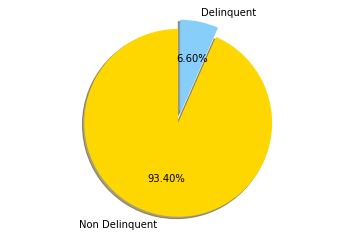

In [19]:
plot_dlq(df_training)

This 6.60 % of people, although seems small; but together they can incur a significant loss for the credit company. 

In order to prevent this loss, a model needs to be made to predict Serious Delinquency of a person in the coming 2yrs. Using this model, the person can take some appropriate steps and draft a financial plan based on the probability to avoid financial hardships. This model can even be used by banks/ credit card companies in their decision making.

We will be using Random Forest Regression for building this model.

In [7]:
rf_fit = RF(df_training)

0.885815607
{'warm_start': False, 'oob_score': True, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 200, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': None}
AUC - ROC :  0.834119567515


In [10]:
X_test  = df_testing.drop("SeriousDlqin2yrs",axis=1)
Y_pred = rf_fit.predict(X_test)
#print(Y_pred[0:25])

In [11]:
prediction = pd.DataFrame({
        "Id": df_testing['Unnamed: 0'],
        "Probability": Y_pred
    })

In [13]:
prediction.to_csv('submission.csv', index=False)